# Pneumothorax Localization (Faster R-CNN)

## SIIM-ACR Dataset on Pneumothorax

- TODO: data augmentation using translate- crop and zoom-transforms

In [12]:
from data.dicom import DICOMFolderDataset

# balanced samples of the SIIM-ACR dataset
valid_data = DICOMFolderDataset('siim-acr-data/dev-pneumothorax/**/**/*.dcm', 'siim-acr-data/dev-sample.csv')
train_data = DICOMFolderDataset('siim-acr-data/train-pneumothorax/**/**/*.dcm', 'siim-acr-data/train-sample.csv')

### Pneumothorax Studies

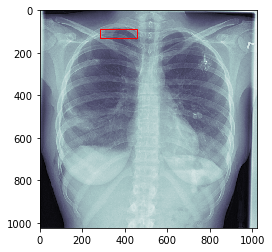

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

# choose a study from the datset
data, label = valid_data.__getitem__(6)

img = data.asnumpy()*255
gtbox = label.asnumpy()

# chest xray image
ax.imshow(img, cmap=plt.cm.bone, interpolation='none')

# ground truth bounding box in corner format
gt = patches.Rectangle((gtbox[0], gtbox[1]), gtbox[2]-gtbox[0], gtbox[3]-gtbox[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(gt)
plt.show()

## Faster R-CNN Detection Network

In [4]:
import mxnet as mx
from network.rcnn import RoentgenFasterRCNN

ctx = mx.cpu(0)

data = mx.sym.var('data')
labels = mx.sym.var('labels')# change manually to corner format

pneumothorax = RoentgenFasterRCNN(num_classes=2, Nt=0.7, joint_training=False, sizes=[0.25,0.15,0.05], ratios=[2,1,0.5])
pneumothorax.hybridize()

# Kaiming initialization from uniform [-c,c] c = sqrt(2/Nin) 
pneumothorax.collect_params().initialize(mx.init.Xavier(factor_type='in', magnitude=0.44444), ctx=ctx)

bboxes,classes = pneumothorax(data)

NameError: name 'rois' is not defined

In [3]:
import time
from mxnet import nd

study = 8
ctx = mx.cpu(0)

data, label = valid_data.__getitem__(study)
data = nd.broadcast_to(data.reshape(1,1,1024,1024),(2,1,1024,1024))
X = nd.array(data.reshape((2, 1, 1024, 1024)), ctx=ctx)

start_time = time.time()
bboxes,classes = pneumothorax(X)

## Region Proposal Network (RPN)

In [13]:
from mxnet import gluon

# Region Proposal Network trained on auxiliary RPN head
pneumothorax = gluon.nn.SymbolBlock.imports("model/roentgen-pneumothorax-rpn-symbol.json", ['data'], "model/roentgen-pneumothorax-rpn-0252.params", ctx=ctx)

In [14]:
pneumothorax

SymbolBlock(
<Symbol group [cls_scores, bbox_offsets]> : 1 -> 2
)

In [11]:
import time
from mxnet import nd

study = 1
data, label = valid_data.__getitem__(study)

X = nd.array(data.reshape((1, 1, 1024, 1024)), ctx=ctx)

p = nd.broadcast_to(anchor_points.reshape(1,1,2,32,32), (1,9,2,32,32))
s = nd.broadcast_to(anchor_boxes.reshape(1,9,2,1,1),(1,9,2,32,32)) # aw = ah = s*sqrt(r)
A = nd.concat(p,s,dim=2)

start_time = time.time()
s,b = pneumothorax(X)

s = nd.sigmoid(s)
B = A + b.reshape(1,9,4,32,32)
print("--- %.2f ms ---" % (time.time()*1000 - start_time*1000))

NameError: name 'anchor_points' is not defined

## Non-Maximum Suppression (NMS)

In [8]:
s.max()


[0.00150017]
<NDArray 1 @cpu(0)>

In [9]:
cond = s.reshape(-1) >= 0.001
cls = nd.contrib.boolean_mask(s.reshape(-1), cond)

In [10]:
x = nd.contrib.boolean_mask(B[:,:,0,:,:].reshape(-1), cond)
y = nd.contrib.boolean_mask(B[:,:,1,:,:].reshape(-1), cond)
w = nd.contrib.boolean_mask(B[:,:,2,:,:].reshape(-1), cond)
h = nd.contrib.boolean_mask(B[:,:,3,:,:].reshape(-1), cond)

In [11]:
bbox = []

for n in range(cls.size):
    bbox.append(nd.array([x[n].asscalar(),y[n].asscalar(),w[n].asscalar(),h[n].asscalar()])*1024)

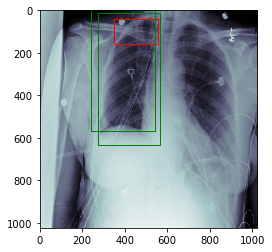

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

data, label = valid_data.__getitem__(study)

img = data.asnumpy()*255
gtbox = label.asnumpy()*1024

# view CT scan
ax.imshow(img, cmap=plt.cm.bone, interpolation='none')

gt = patches.Rectangle((gtbox[0]-int(gtbox[2]/2),gtbox[1]-int(gtbox[3]/2)),gtbox[2],gtbox[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(gt)

for n in range(cls.size):
    pred = patches.Rectangle((bbox[n][0].asscalar()-int(bbox[n][2].asscalar()/2),bbox[n][1].asscalar()-int(bbox[n][3].asscalar()/2)),bbox[n][2].asscalar(),bbox[n][3].asscalar(),linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(pred)

plt.show()

In [13]:
bbox

[
 [389.94513 280.95636 303.42294 574.1897 ]
 <NDArray 4 @cpu(0)>,
 
 [420.1864  321.15005 294.90228 620.8915 ]
 <NDArray 4 @cpu(0)>]

In [14]:
gtbox

array([453., 100., 210., 116.], dtype=float32)